### Imports

In [1]:
!export CUDA_VISIBLE_DEVICES=-1
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

In [2]:
%matplotlib inline

### Load data

In [3]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### Take a look at the data

In [4]:
images = mnist.test.images[:10]
labels = np.argmax(mnist.test.labels[:10], axis=1)

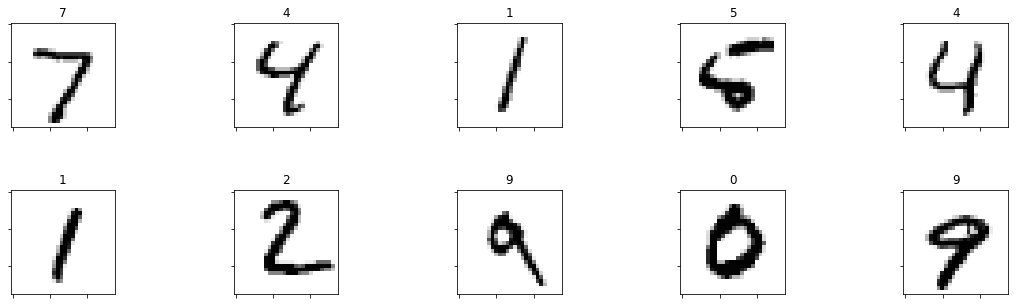

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(20, 5))
plt.grid(False)
plt.subplots_adjust(hspace=0.6, wspace=0)


for i, label in enumerate(labels):
    k = ax[i % 2, i % 5]
    k.set_yticklabels([])
    k.set_xticklabels([])
    k.set_title(label)
    k.imshow(-images[i].reshape([28, 28]), cmap='gray')
    


### Pick some hyperparameters

In [6]:
learning_rate = 0.001
num_steps = 500
batch_size = 64
display_step = 10

### Pick the size of input features, number of output classes and dropout rate

In [7]:
num_input = 28 * 28 
num_classes = 10 
dropout_rate = 0.9

### Initialize input for tf.Graph()

In [8]:
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) 

### Create sample convolutional & max-pool layers 

In [9]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

### Create a net with two convolutional layers and one fully connected layer

In [10]:
def conv_net(x):

    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)

    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fcl = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fcl = tf.add(tf.matmul(fcl, weights['wd1']), biases['bd1'])
    fcl = tf.nn.relu(fcl)
    
    # Dropout
    fcl = tf.nn.dropout(fcl, dropout_rate)

    # Output, class prediction
    out = tf.add(tf.matmul(fcl, weights['out']), biases['out'])
    return out

### Initialize weights and biases

In [11]:
weights = {
    # 5x5 convolutional layer, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 convolutional layer, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected layer, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]))}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))}

### Initialize model saver

In [12]:
saver = tf.train.Saver()

### Training 

In [13]:
with tf.Session() as sess:
    
    logits = conv_net(X)
    prediction = tf.nn.softmax(logits)
    
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)
    
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    sess.run(tf.global_variables_initializer())

    for step in range(1, num_steps+1):
        # Forward step
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Backpropagation step
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: 1.0})

        if step % display_step == 0 or step == 1:
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y,keep_prob: 1.0})
            print(f'Step: {step},  Losses: {loss:.4f}, Train accuracy: {100 * acc:.3f}%')

    # Count accuracy on the training dataset
    test_acc = sess.run(accuracy, feed_dict={X: mnist.test.images[:256], Y: mnist.test.labels[:256], keep_prob: 1.0})
    saver.save(sess, 'pred/model.ckpt')

    print(f'\n\nTesting Accuracy: {100 * test_acc:.2f}%')


ResourceExhaustedError: OOM when allocating tensor with shape[3136,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: Variable_2/Adam_1/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable_2/Assign"], _grappler_relax_allocator_constraints=true, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Variable_2/Adam_1, Variable_2/Adam/Initializer/zeros)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'Variable_2/Adam_1/Assign', defined at:
  File "/usr/local/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/local/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/usr/local/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-b8a7545c8b48>", line 8, in <module>
    train_op = optimizer.minimize(loss_op)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 410, in minimize
    name=name)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 588, in apply_gradients
    self._create_slots(var_list)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/training/adam.py", line 135, in _create_slots
    self._zeros_slot(v, "v", self._name)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 1134, in _zeros_slot
    new_slot_variable = slot_creator.create_zeros_slot(var, op_name)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 181, in create_zeros_slot
    colocate_with_primary=colocate_with_primary)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 155, in create_slot_with_initializer
    dtype)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 65, in _create_slot_var
    validate_shape=validate_shape)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1467, in get_variable
    aggregation=aggregation)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1217, in get_variable
    aggregation=aggregation)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 527, in get_variable
    aggregation=aggregation)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 481, in _true_getter
    aggregation=aggregation)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 903, in _get_single_variable
    aggregation=aggregation)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2443, in variable
    aggregation=aggregation)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2425, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2406, in default_variable_creator
    constraint=constraint)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 259, in __init__
    constraint=constraint)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 412, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 216, in assign
    validate_shape=validate_shape)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 60, in assign
    use_locking=use_locking, name=name)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/yurii/Work/Ralabs/Machine-Learning-sandbox/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3136,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: Variable_2/Adam_1/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable_2/Assign"], _grappler_relax_allocator_constraints=true, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Variable_2/Adam_1, Variable_2/Adam/Initializer/zeros)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

